# Blockchain analysis

In case you know nothing about the Bitcoin and Blockchain, you can start by watching the following video.

In [ ]:
import IPython.display
IPython.display.HTML('<iframe width="750" height="430" src="https://www.youtube.com/embed/Lx9zgZCMqXE?rel=0&amp;controls=1&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Basic setup

Here we will import the `pyspark` module and set up a `SparkSession`. By default, we'll use a `SparkSession` running locally, with one Spark executor; we're dealing with small data, so it doesn't make sense to run against a cluster, but the `local[1]` can be changed with the ip of the Spark cluster.


In [ ]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *

spark = SparkSession.builder \
                    .master("local[4]") \
                    .config("spark.driver.memory", "4g") \
                    .getOrCreate()

sc = spark.sparkContext

## Loading the data

To obtain the graph representing the transaction in the Bitcoin network, we need to load set of nodes representing the wallets (fingerprints of the public keys) and the set of edges representing each transaction. For this example we will use two parquet files that were generated from the blockchain data by this [convertor](https://github.com/Jiri-Kremser/bitcoin-insights/tree/master/parquet-converter).

In [ ]:
raw_nodes = spark.read.load("/tmp/nodes1.parquet") \
                      .withColumnRenamed("_1", "id") \
                      .withColumnRenamed("_2", "Address")
raw_nodes.show(5)

As you can see, each record in the Address column contains a string `bitcoinaddress_<hash>`, where the hash is the actual address. Let's remove the redundant prefix.

In [ ]:
nodes = raw_nodes.withColumn("Address", regexp_replace("Address", "bitcoinaddress_", "")).cache()
nodes.show(5)

We can also verify, that these addresses are real on https://blockchain.info/address/. 

Example:
 1. get a random BTC address
 1. create the link from the address

In [ ]:
random_address = nodes.rdd.takeSample(False, 1)[0][1]
IPython.display.Markdown('link of the random wallet: https://blockchain.info/address/' + random_address)

In [ ]:
raw_edges = spark.read.load("/tmp/edges1.parquet") \
                      .withColumnRenamed("srcId", "src") \
                      .withColumnRenamed("dstId", "dst") \
                      .drop("attr") \
                      .cache()
raw_edges.show(5)
raw_edges.count()

## Data cleansing

Remove the self-loops.

In [ ]:
edges = raw_edges.filter("src != dst")
edges.show(5)
edges.count()

## Constructing the graph representation

In [ ]:
from graphframes import *

g = GraphFrame(nodes, edges).cache()

#### Get the vertex degrees

In [ ]:
vertexDegreesAndIds = g.inDegrees.join(g.outDegrees, "id")
vertexDegrees = vertexDegreesAndIds.drop("id")
vertexDegrees.show(5, False)

#### Calculate some basic statistics

In [ ]:
vertexDegrees.describe() \
             .show()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
from scipy import stats
sns.set(color_codes=True)

_ = sns.countplot([int(i.inDegree) for i in vertexDegrees.sample(False, 0.003).select("inDegree").collect()])

In [ ]:
_ = sns.countplot([int(i.outDegree) for i in vertexDegrees.sample(False, 0.003).select("outDegree").collect()])

In [ ]:
sns.jointplot(x="inDegree", y="outDegree", data=vertexDegrees.sample(False, 0.01, 42).toPandas());

In [ ]:
vertexDegrees.select(corr("inDegree", "outDegree")) \
             .show()

In [ ]:
probs = [i*1.0/20 for i in range(0,20)]
quantiles = vertexDegrees.approxQuantile("inDegree", probs, 0.03)
quantiles

In [ ]:
import pandas as pd
p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})

sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

In [ ]:
def create_graph(id):
    nodes = spark.read.load("/tmp/nodes" + id +".parquet").withColumnRenamed("_1", "id")
    raw_edges = spark.read.load("/tmp/edges" + id +".parquet") \
                          .withColumnRenamed("srcId", "src").withColumnRenamed("dstId", "dst") \
                          .drop("attr")

    edges = raw_edges.filter("src != dst")
    self_loops = raw_edges.count() - edges.count()
    print("Graph " + id + " - self-loops count: " + str(self_loops))
    g = GraphFrame(nodes, edges)
    degrees = g.inDegrees.join(g.outDegrees, "id").drop("id")
    return [g, degrees]

# g1 ~ blkfiles 051-054 ~ 2013~04
# g2 ~ blkfiles 401-404 ~ 2015~12
g1, degrees1 = create_graph("1")
g2, degrees2 = create_graph("2")

In [ ]:
degrees1.describe().show()
degrees2.describe().show()

In [ ]:
def plot_quantiles(degrees):
    probs = [i*1.0/15 for i in range(0,15)]
    quantiles = degrees.approxQuantile("outDegree", probs, 0.03)
    p_df = pd.DataFrame({'quantiles': quantiles, 'probabilities': probs})
    sns.lmplot(x="probabilities", y="quantiles", fit_reg=False, data=p_df)

plot_quantiles(degrees1)
plot_quantiles(degrees2)

#### Find some patterns in the graph

In [ ]:
graph_with_degrees = GraphFrame(g.vertices.join(vertexDegreesAndIds, "id"), edges)
graph_with_degrees.vertices.show()


motifs = graph_with_degrees.find("(a)-[]->(b)") \
                           .filter("a.outDegree > 1000") \
                           .filter("a.inDegree = 1") \
                           .filter("b.outDegree = 1") \
                           .filter("b.inDegree > 1000")
motifs.show()
motifs.count()

## Visualization of a sub-graph

Our data contain a lot of nodes and edges so let's show only a small fraction of the transaction graph. We will show all the outgoing transaction of particular bitcoin address.

In [ ]:
from pyspark.sql.functions import col
import random

vertexOutDegrees = g.outDegrees
senders = vertexOutDegrees.join(nodes, vertexOutDegrees.id == nodes.id) \
                          .drop("id") \
                          .orderBy("outDegree", ascending=False)

# feel free to use any address that is present in the dataset
address = senders.take(1000)[999].Address

sub_graph = g.find("(src)-[e]->(dst)") \
             .filter(col('src.Address') == address)
    
def node_to_dict(r):
    return {
        'id': r[0],
        'label': r[1],
        'x': random.uniform(0,1),
        'y': random.uniform(0,1),
        'size': random.uniform(0.2,1)
    }

sub_nodes = sub_graph.select("dst.id", "dst.Address").distinct()
sub_edges = sub_graph.select("e.src", "e.dst")

target_nodes_dict = map(node_to_dict, sub_nodes.collect())

def edge_to_dict(i, r):
    return {
        'id': i,
        'source': r[0],
        'target': r[1]
    }

sub_edges_dict = [edge_to_dict(i, r) for i, r in enumerate(sub_edges.collect())]

target_nodes_dict.append({
    'id': sub_edges.first()['src'],
    'label': address,
    'color': '#999',
    'x': -1,
    'y': 0.5,
    'size': 2
})

Now we are ready to show the data using the [sigmajs](sigmajs.org) library.

In [ ]:
%%javascript
require.config({
    paths: {
        sigmajs: 'https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.0/sigma.min'
    }
});

require(['sigmajs']);

In [ ]:
from IPython.core.display import display, HTML
from string import Template
import json

js_text_template = Template(open('js/sigma-graph.js','r').read())

graph_data = { 'nodes': target_nodes_dict, 'edges': sub_edges_dict }

js_text = js_text_template.substitute({'graph_data': json.dumps(graph_data),
                                       'container': 'graph-div'})

html_template = Template('''
<div id="graph-div" style="height:400px"></div>
<script> $js_text </script>
''')

HTML(html_template.substitute({'js_text': js_text}))

Or we can visualize using `networkx` and `matplotlib`

In [ ]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(sub_edges.collect())

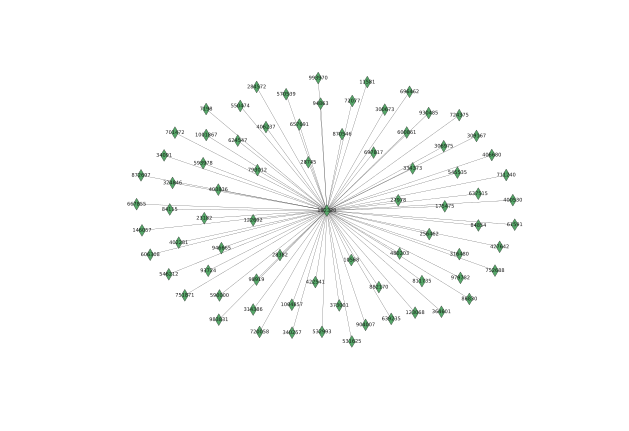

In [ ]:
import matplotlib.pyplot as plt
options = {
    'node_color': 'g',
    'node_size': 70,
    'width': 0.2,
    'node_shape': 'd',
    'with_labels': True,
    'font_size': 5,
}
nx.draw(G, **options)

We can also show some random sub-graph using random layout

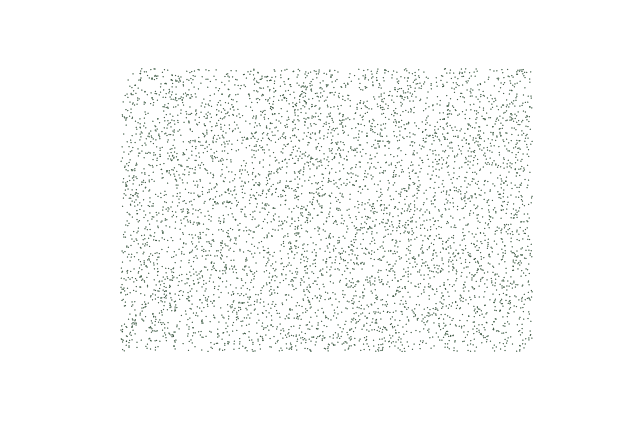

In [ ]:
sample_data = edges.sample(False, 0.0004).collect()
G2 = nx.Graph()
G2.add_edges_from(sample_data)

options = {
    'node_color': 'g',
    'node_size': 1,
    'width': 0.05,
    'node_shape': 'o',
    'vmin': 100.1,
    'vmax': 10.1,
    'with_labels': False,
}
nx.draw_random(G2, **options)

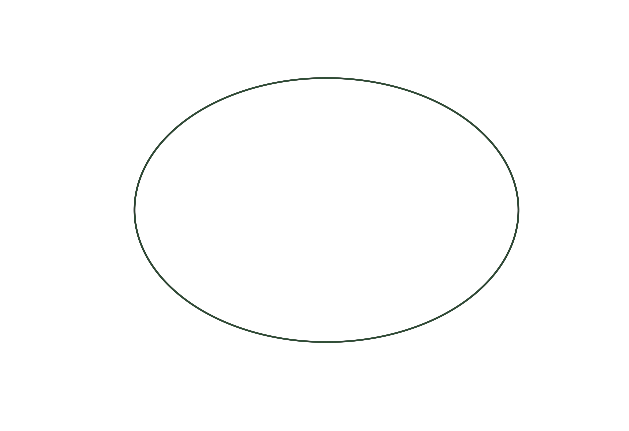

In [ ]:
nx.draw_shell(G2, **options)

using spring algorithm

**Warning: this may take couple of minutes to render**

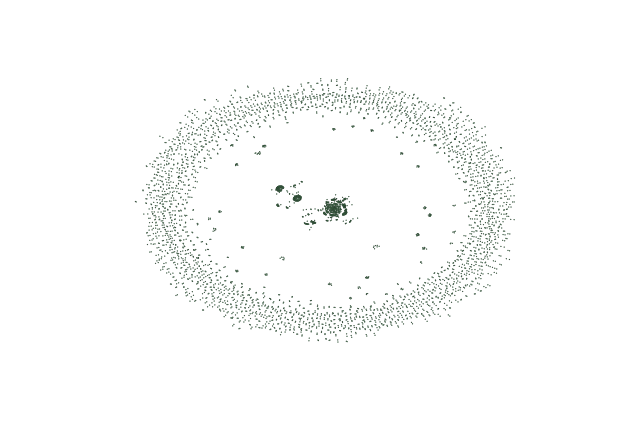

In [ ]:
nx.draw_spring(G2, **options)

Unfortunatelly, the plotting mechanism in `networkx` doesn't support the zooming, but it's possible to export the data and explore them by tools like `Gephi`.